In [1]:
from mmdet.apis import init_detector, inference_detector
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import matplotlib.colors as mcolors

In [2]:
#config = 'mmdet_configs/configs/faster_rcnn/faster_rcnn_r50_fpn_2x_coco.py'
#config = 'mmdet_configs/configs/yolo/yolov3_d53_fp16_mstrain-608_273e_coco.py'
config = 'cracks_tood.py'
#checkpoint = 'faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth'
#checkpoint = 'yolov3_d53_fp16_mstrain-608_273e_coco_20210517_213542-4bc34944.pth'
checkpoint = 'tood.pth'
device = 'cuda:0'

In [3]:
model = init_detector(config, checkpoint, device)

load checkpoint from local path: tood.pth


2022-06-28 08:51:08,171 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-06-28 08:51:08,173 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-06-28 08:51:08,174 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-06-28 08:51:08,176 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-06-28 08:51:08,178 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-06-28 08:51:08,180 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-06-28 08:51:08,182 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-06-28 08:51:08,184 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-06-28 08:51:08,187 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 

In [4]:
label_names=['Arrachement_pelade', 'Faiencage', 'Nid_de_poule',
                 'Transversale', 'Longitudinale', 'Reparation']

In [5]:
colors_list = [[1,0,0], [0,1,0], [0,0,1], [1,0,1], [0,1,1], [1,1,0]]
cmaps = []
for ic in range(len(label_names)):
    colors = [(colors_list[ic][0], colors_list[ic][1], colors_list[ic][2], c) for c in np.linspace(0,1,100)]
    cmaps.append( mcolors.LinearSegmentedColormap.from_list(f'mycmap{ic}', colors, N=5) )

In [6]:
def parse_yolo_annotation(annotation_txtpath):
    """ Parse a yolo annotation file. """
    annotations = []
    with open(annotation_txtpath, "rt") as f_in:
        for line in f_in.readlines():
            line = line.strip()

            cls, x_center, y_center, width, height = line.split()

            annotations.append(
                {
                    "class_index": int(cls),
                    "x_center": float(x_center),
                    "y_center": float(y_center),
                    "width": float(width),
                    "height": float(height),
                }
            )
    return annotations


def yolo_annotations_to_box(yolo_annotations, image, label_names):
    """ Convert a yolo annotation list to (x1, y1, x2, y2) coordinates."""
    image_width = image.shape[1]
    image_height = image.shape[0]
    box_annotations = [[] for _ in range(len(label_names))]

    for annotation in yolo_annotations:
        x1 = int(round((annotation["x_center"]-annotation['width']) * image_width))
        if x1 < 0:
            x1 = 0
        y1 = int(round((annotation["y_center"]-annotation['height']) * image_height))
        if y1 < 0:
            y1 = 0
        x2 = int(round((annotation["x_center"]+annotation['width']) * image_width))
        y2 = int(round((annotation["y_center"]+annotation['height']) * image_height))
        box_annotations[annotation['class_index']].append([x1,y1,x2,y2])

    for c in range(len(label_names)):
        if len(box_annotations[c]) > 0:
            box_annotations[c] = np.stack(box_annotations[c])

    return box_annotations

In [7]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [8]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
              255).astype(np.uint8)
    return masked

In [9]:
def iou(boxes, box):
    box = np.asarray(box)
    tl = np.maximum(boxes[:,:2], box[:2])
    br = np.minimum(boxes[:,2:], box[2:])
    intersection = np.prod(br - tl, axis=1) * np.all(tl < br, axis=1).astype(float)
    area1 = np.prod(boxes[:,2:] - boxes[:,:2], axis=1)
    area2 = np.prod(box[2:] - box[:2])
    return intersection / (area1 + area2 - intersection)

In [10]:
def generate_saliency_map(image,
                          n_classes,
                          target_boxes,
                          prob_thresh=0.5,
                          grid_size=(16, 16),
                          n_masks=5000,
                          seed=0):
    np.random.seed(seed)
    image_h, image_w = image.shape[:2]
    res = [
            [np.zeros((image_h, image_w), dtype=np.float32) for _ in range (len(target_boxes[ic]))]
            for ic in range(n_classes)
    ]
    for i in tqdm.notebook.tqdm(range(n_masks)):
        mask = generate_mask(image_size=(image_w, image_h),
                             grid_size=grid_size,
                             prob_thresh=prob_thresh)
        masked = mask_image(image, mask)
        out = inference_detector(model, masked)
        for ic in range(n_classes):
            boxes = target_boxes[ic]
            pred = out[ic]
            if len(pred) > 0 and len(boxes) > 0:
                score = np.stack([iou(boxes, box) * score for *box, score in pred]).max(axis=0)
                for ib in range(len(target_boxes[ic])):
                    res[ic][ib] += mask * score[ib]
    return res

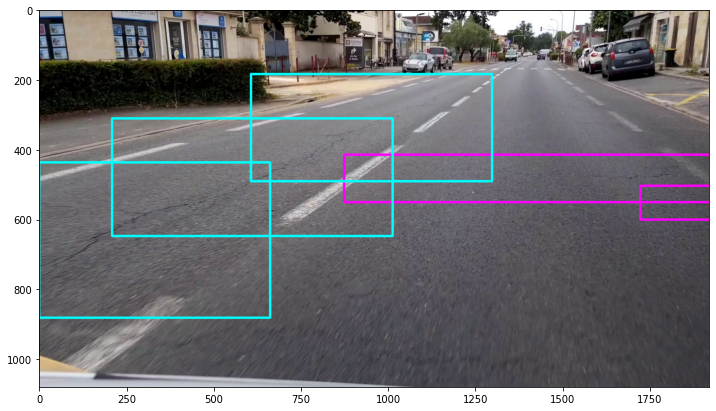

In [11]:
image_path = 'images/no_contract_CD_33_20200716_085848_868_000269.jpg'

image = cv2.imread(image_path)
#scale = 600 / min(image.shape[:2])
#image = cv2.resize(image,
#                   None,
#                   fx=800 / image.shape[1],
#                   fy=640 / image.shape[0],
#                   interpolation=cv2.INTER_AREA)

yolo_ann = parse_yolo_annotation(image_path.replace('.jpg', '.txt'))
target_boxes = yolo_annotations_to_box(yolo_ann, image, label_names)

res = image.copy()
for ic in range(len(label_names)):
    for i in range(len(target_boxes[ic])):
            cv2.rectangle(res, target_boxes[ic][i,:2], target_boxes[ic][i, 2:],
                          (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)
            
plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

3 Transversale (0, 545, 279, 587) 0.476484
3 Transversale (1194, 443, 1856, 495) 0.32746193
4 Longitudinale (0, 587, 303, 773) 0.63074297
4 Longitudinale (367, 402, 801, 578) 0.5465946
4 Longitudinale (745, 316, 956, 431) 0.35640538
4 Longitudinale (768, 265, 1084, 412) 0.33675018


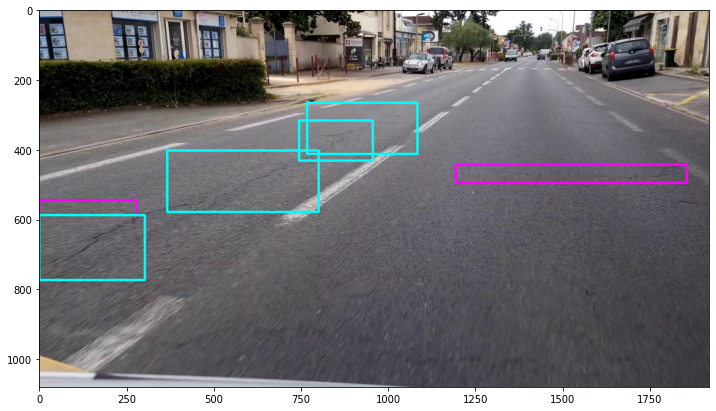

In [103]:
out = inference_detector(model, image)
res = image.copy()
pred_boxes = [[] for _ in range(len(label_names))]
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.3:
            continue
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        pred_boxes[i].append(box)
        cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)
    if len(pred_boxes[i]) > 0:
        pred_boxes[i] = np.stack(pred_boxes[i])

plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

In [41]:
saliency_map = generate_saliency_map(image,
                                     n_classes=len(label_names),
                                     target_boxes=target_boxes,
                                     prob_thresh=0.5,
                                     grid_size=(16, 16),
                                     n_masks=6)

  0%|          | 0/6 [00:00<?, ?it/s]

/home/theo/workdir/mmdet/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


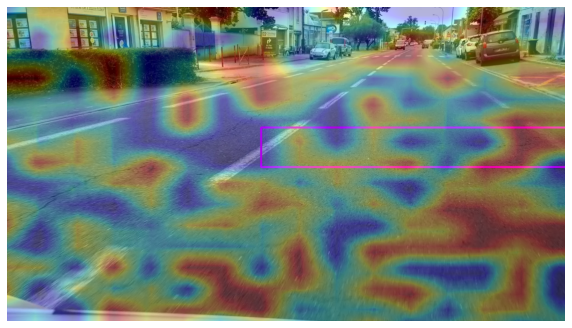

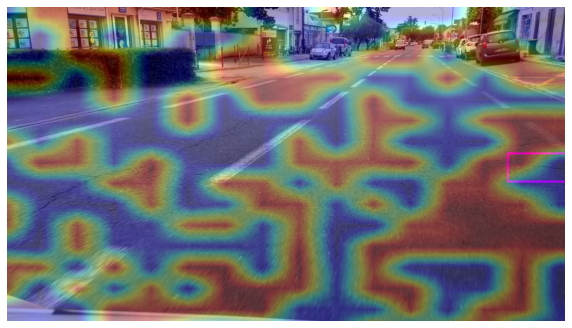

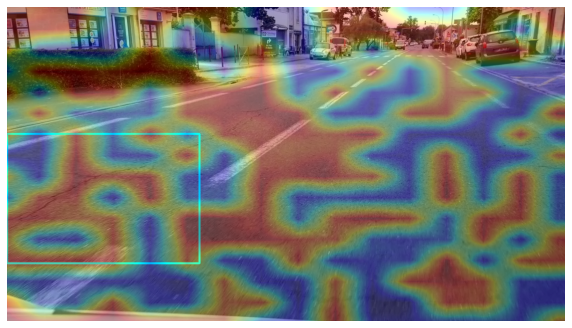

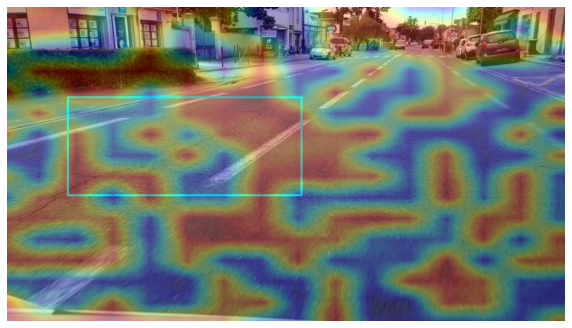

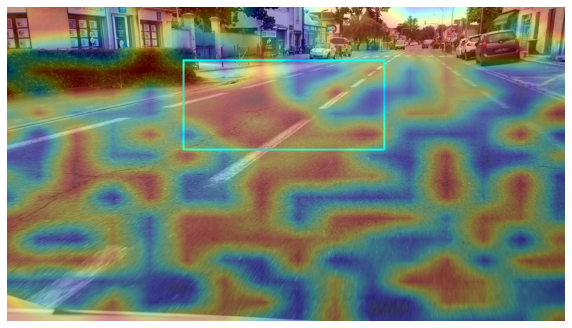

In [42]:
for ic, boxes in enumerate(target_boxes):
    for ib in range(len(boxes)):
        image_with_bbox = image.copy()
        cv2.rectangle(image_with_bbox, tuple(boxes[ib, :2]),
                      tuple(boxes[ib, 2:]), (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)

        plt.figure(figsize=(10, 8))
        plt.imshow(image_with_bbox[:, :, ::-1])

        plt.imshow(saliency_map[ic][ib], cmap='jet', alpha=0.3)

        plt.axis('off')
        plt.show()

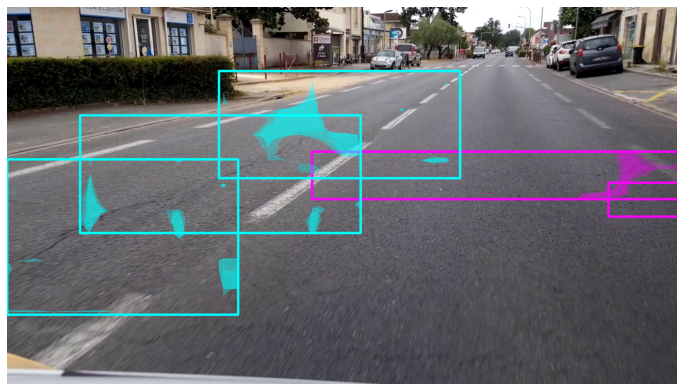

In [57]:
image_with_bbox = image.copy()
for ic in range(len(label_names)):
    for i in range(len(target_boxes[ic])):
        cv2.rectangle(image_with_bbox, tuple(target_boxes[ic][i,:2]),
                      tuple(target_boxes[ic][i,2:]), (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)
        
plt.figure(figsize=(12, 12))
plt.imshow(image_with_bbox[:, :, ::-1])

seg_map = np.zeros((image.shape[0], image.shape[1])) # for annotation file

for ic in range(len(label_names)):
    if len(target_boxes[ic]) == 0:
        continue

    # keep segmentation map within annotated bboxes
    box_mask = np.full(saliency_map[ic][0].shape, False)
    for x1,y1,x2,y2 in target_boxes[ic]:
        box_mask[y1:y2+1, x1:x2+1] = True

    for ib in range(len(target_boxes[ic])):
        score_mask = saliency_map[ic][ib]>np.percentile(saliency_map[ic][ib], 95)
        segmentation_mask = score_mask & box_mask

        plt.imshow(segmentation_mask, cmap=cmaps[ic], alpha=0.3)
        seg_map = np.where(segmentation_mask, ic+1, seg_map) # for annotation file
    
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


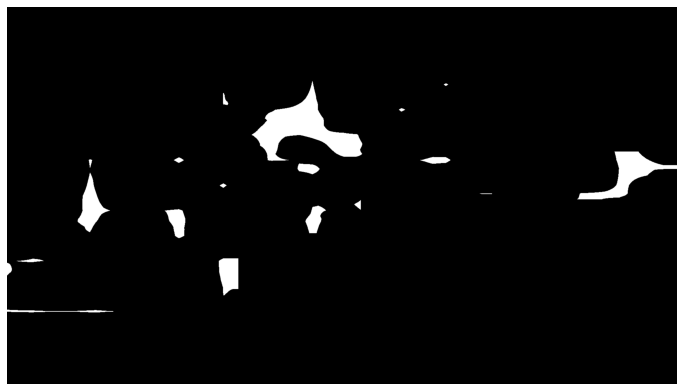

True

In [58]:
seg_map = np.transpose(np.stack([seg_map,seg_map,seg_map]), (1,2,0))
plt.figure(figsize=(12, 12))
plt.imshow(seg_map)
plt.axis('off')
plt.show()

cv2.imwrite('test.png', seg_map)

In [71]:
seg_annot = cv2.imread('../mmdet/test/no_contract_CD_33_20200716_085848_868_000269.png')

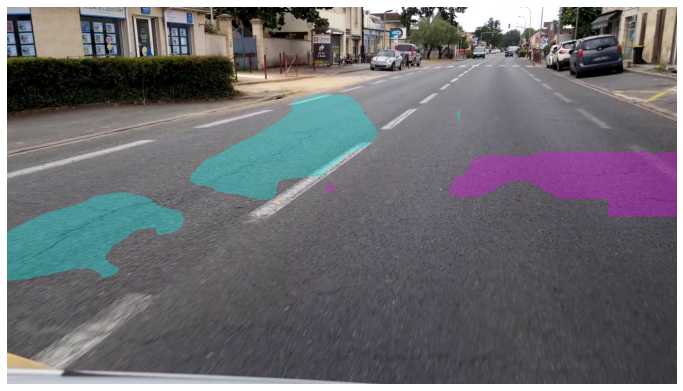

In [74]:
plt.figure(figsize=(12, 12))
plt.imshow(image[:, :, ::-1])
seg = seg_annot[:,:,0]

for ic in np.unique(seg):
    if ic == 0:
        continue
    seg_tmp = np.where(seg==ic, True, False)
    plt.imshow(seg_tmp, cmap=cmaps[ic-1], alpha=0.3)
    
plt.axis('off')
plt.show()